# KIDNEY STONE DETECTION MADE EASY: A POWERFUL CNN SVM SYSTEM WITH A USER-FRIENDLY TOUCH 

# Importing Libararies

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
import random
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 
from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import gradio as gr

# Preparing Training Data

In [9]:
folder_path = "./CT_Images/Train"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [10]:
df.head()

,filename,category
0,Normal\Normal- (1).jpg,Normal
1,Normal\Normal- (10).jpg,Normal
2,Normal\Normal- (100).jpg,Normal
3,Normal\Normal- (1000).jpg,Normal
4,Normal\Normal- (101).jpg,Normal


In [11]:
df.tail()

,filename,category
2995,Stone\Stone- (995).jpg,Stone
2996,Stone\Stone- (996).jpg,Stone
2997,Stone\Stone- (997).jpg,Stone
2998,Stone\Stone- (998).jpg,Stone
2999,Stone\Stone- (999).jpg,Stone


<Axes: xlabel='category'>

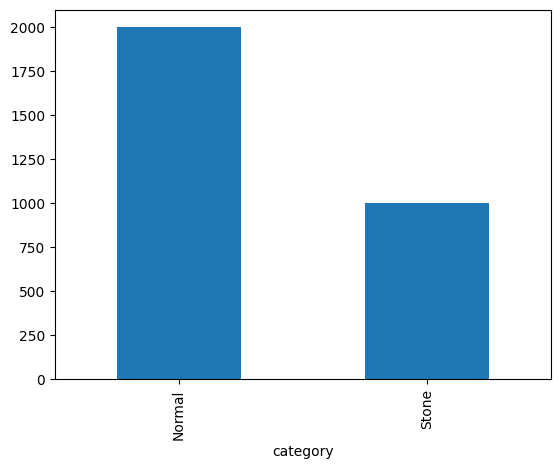

In [12]:
df['category'].value_counts().plot.bar()

# Visualizing Data

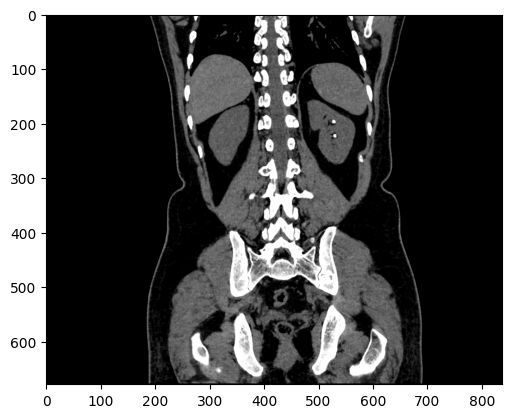

In [13]:
sample = random.choice(filenames)
image = load_img("./CT_Images/Train/"+sample)
plt.imshow(image)

# CNN 

In [15]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
#CALL BACKS

In [18]:
earlystop = EarlyStopping(patience=10)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [20]:
callbacks = [earlystop, learning_rate_reduction]

# PREPARING  DATA

In [22]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

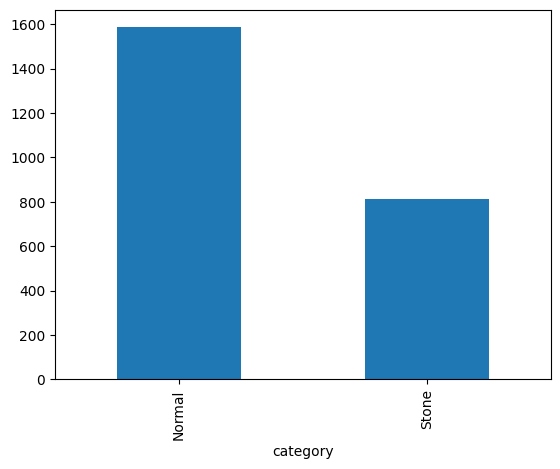

In [23]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

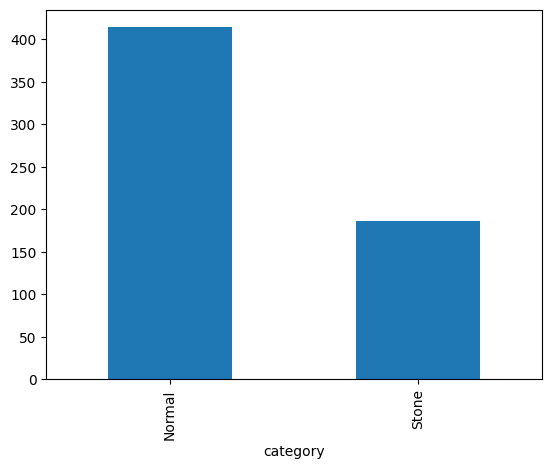

In [24]:
validate_df['category'].value_counts().plot.bar()

# TRAIN AND VALIDATION GENERATOR

In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


In [28]:
# Visulaizing the output of data gen

In [29]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./CT_Images/Train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


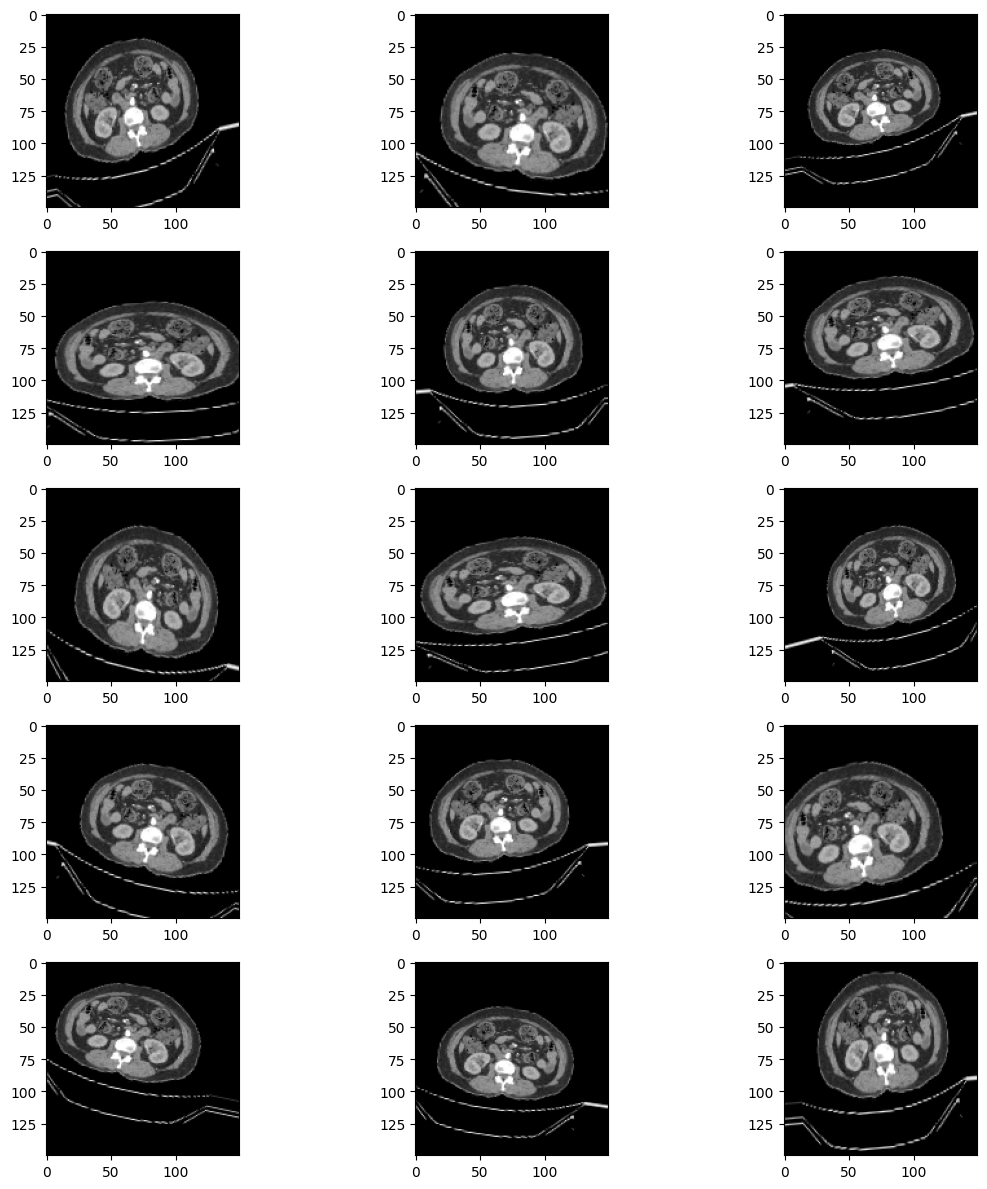

In [30]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# FITTING MODEL

In [32]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
# Adjust steps_per_epoch based on actual generator output size
steps_per_epoch = min(len(train_generator), train_df.shape[0] // 30)
validation_steps = min(len(validation_generator), validate_df.shape[0] // 30)

In [34]:
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 747ms/step - accuracy: 0.6389 - loss: 0.7939 - val_accuracy: 0.2933 - val_loss: 1.8665 - learning_rate: 0.0010
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 841ms/step - accuracy: 0.7995 - loss: 0.4976 - val_accuracy: 0.3200 - val_loss: 5.4987 - learning_rate: 0.0010
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 60s 747ms/step - accuracy: 0.8540 - loss: 0.3878 - val_accuracy: 0.5100 - val_loss: 2.5323 - learning_rate: 0.0010
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 782ms/step - accuracy: 0.8466 - loss: 0.3613 - val_accuracy: 0.3533 - val_loss: 1.7335 - learning_rate: 0.0010
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8763 - loss: 0.2972
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
80/80 ━━━━━━━━━━━━━━━━━━━━ 53s 657ms/step - accuracy: 0.8762 - loss: 0.2975 - val_accuracy: 0.4233 - val_loss: 1.0490 - learning_rate: 0.0010
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 59s 745ms/step - accuracy: 0.8670 - loss: 0.3097 - val_accuracy: 0.9700 - val_loss: 0.2748 - learning_rate: 5.0000e-04
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoc

In [35]:
#VIZUALIZING TRAINING HSITORY

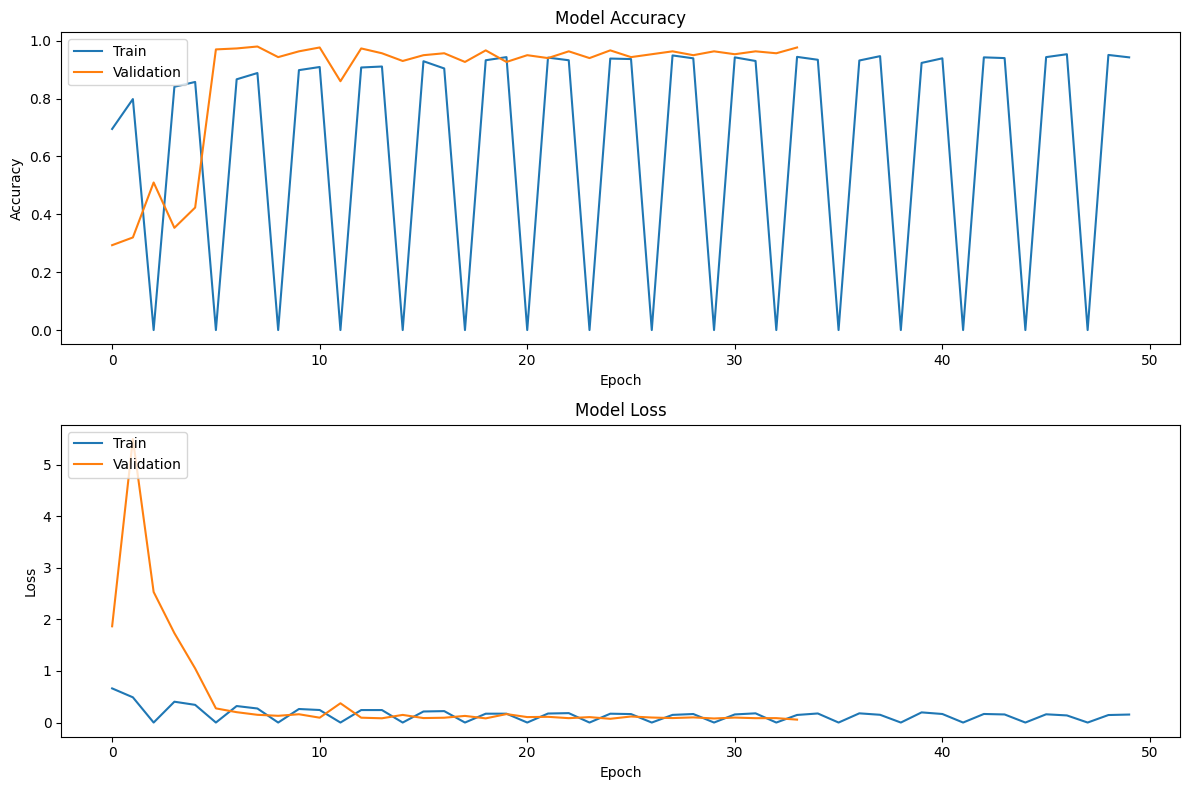

In [36]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
#SAVING CNN MODEL

In [38]:
# Save the model in Keras native format
model.save('kidney_stone_detection_model.keras')


# TESTING DATA

In [40]:
test_folder_path = "./CT_Images/Test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [41]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./CT_Images/Test/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


# PREDICTION

In [43]:
# Calculate the number of steps as an integer
steps = int(np.ceil(test_df.shape[0] / 15))

# Use the calculated steps in the predict function
predictions = model.predict(test_generator, steps=steps)


C:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step


In [44]:
# Assign the predictions to the test_df
test_df['predicted category'] = np.argmax(predictions, axis=-1)


In [45]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [46]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


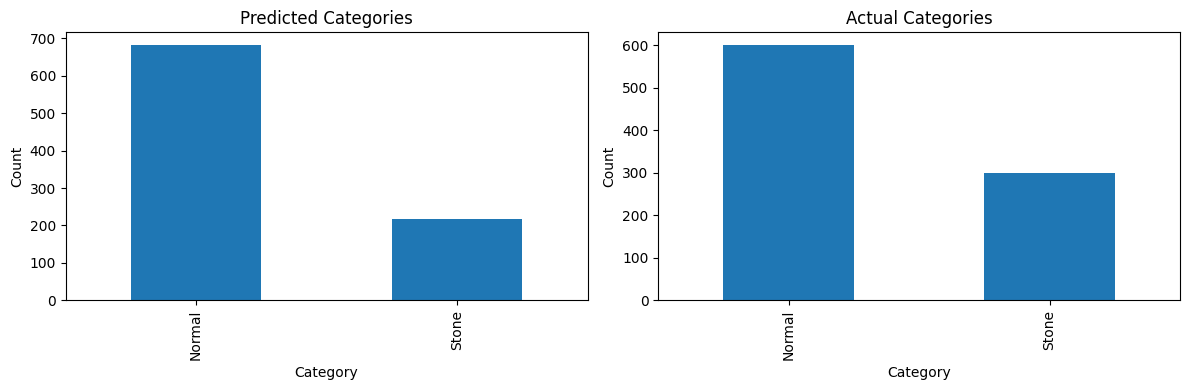

In [47]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

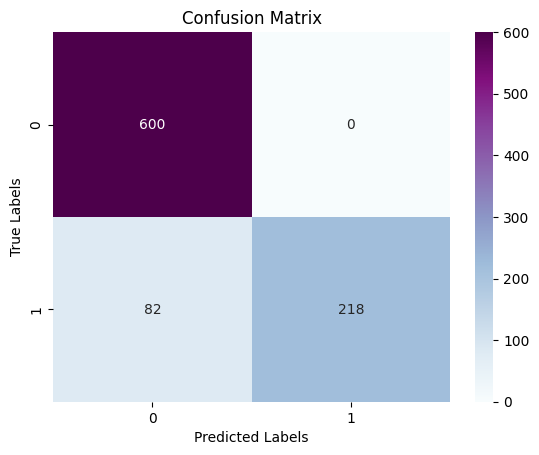

In [48]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images 

In [50]:
# Compile the model (if not already compiled)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can evaluate the model
model.evaluate(test_generator)


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.9841 - loss: 0.0494


[0.2883744537830353, 0.9088888764381409]

# SVM

In [52]:
#Defining a function to read images from the train and test folders
def read_images(path):
    images_list = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images_list.append(img)
    return images_list

In [53]:
#Reading train images from the normal and stone folders
train_normal = read_images('CT_images/Train/Normal')
train_stone = read_images('CT_images/Train/Stone')

In [54]:
#Creating a list of labels for training 
labels = ['Normal' for item in train_normal] + ['Stone' for item in train_stone]

In [55]:
#Defining a function for HOG feature extraction
def extract_features(images):
    feature_list = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), 
                            cells_per_block=(1, 1), visualize=True, channel_axis=2)
        # Resize the HOG features to a fixed size
        fd = np.resize(fd, (2400, 1))
        # Flatten the array to 2 dimensions
        fd = fd.flatten()
        feature_list.append(fd)
    return feature_list

In [56]:
from skimage.feature import hog
from joblib import Parallel, delayed
import numpy as np

# Function to extract HOG features from a single image (no visualization)
def extract_hog_feature(img):
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16), 
             cells_per_block=(1, 1), visualize=False, channel_axis=2)
    return np.resize(fd, (2400, 1)).flatten()

# Parallel feature extraction
def extract_features_parallel(images):
    return Parallel(n_jobs=-1)(delayed(extract_hog_feature)(img) for img in images)

# Run HOG feature extraction in parallel
feature_list_normal = extract_features_parallel(train_normal)
feature_list_stone = extract_features_parallel(train_stone)


In [57]:
print(len(feature_list_normal))
print(len(feature_list_stone))

2000
1000


In [58]:
#Combining the features for both classes
features = feature_list_normal + feature_list_stone

In [59]:
#Reading test images from the normal and stone folders
test_normal = read_images('CT_images/Test/Normal')
test_stone = read_images('CT_images/Test/Stone')

In [60]:
#Creating a list of labels for testing 
test_labels = ['Normal' for item in test_normal] + ['Stone' for item in test_stone]

In [61]:
#Creating a Feature Vector for Test Set
test_feature_list_normal = extract_features(test_normal)
test_feature_list_stone = extract_features(test_stone)

In [62]:
print(len(test_feature_list_normal))
print(len(test_feature_list_stone))

600
300


In [63]:
#Combining the features for both classes
test_features = test_feature_list_normal + test_feature_list_stone

In [64]:
#Splitting the data into train and valid sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size=0.2, random_state=0)

In [65]:
# Print the shape of the first element in the X_train array
print(X_train[0].shape)

# Print the shape of the second element in the X_train array
print(X_train[1].shape)

# Print the shape of the last element in the X_train array
print(X_train[-1].shape)

(2400,)
(2400,)
(2400,)


In [66]:
# Training a SVM Model
svc = SVC(kernel='rbf', C=1, gamma='auto')
svc.fit(X_train, y_train)

SVC(C=1, gamma='auto')

In [67]:
# Predicting the Test Set
y_pred = svc.predict(X_valid)

In [68]:
#Calculating the accuracy
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.7966666666666666


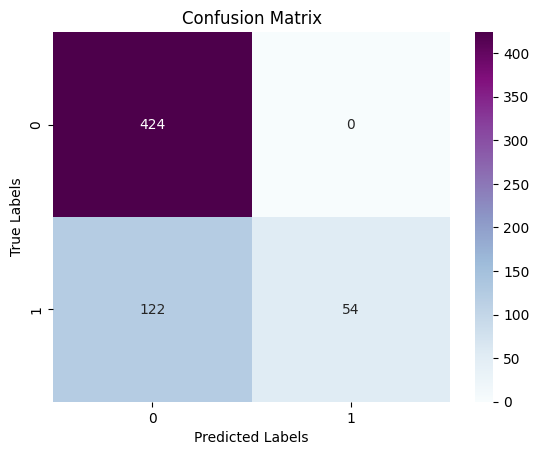

In [69]:
svm_cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

Same case is with the SVM it is also baised towrads the Normal 

# GUI

In [136]:
import joblib
# Load the SVM model
svm_model = joblib.load("svc.pkl")  # Load the trained SVM model


In [137]:
from keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy',  # or any other loss function based on your task
              metrics=['accuracy'])  # Add the metrics you used during training


In [138]:
import sklearn.externals
import joblib
svc = joblib.load("svc.pkl") 

# Custom Tkinter

In [139]:
# Function to Select Image
def browse_btn():
    global image_name
    
    label_cnn.configure(text="")
    label.configure(text="")
    
    image_name = askopenfilename(title='Select Image')
    img = Image.open(image_name)
    img = img.resize((200, 200), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    panel = tk.Label(root, image=img)
    panel.image = img
    panel.grid(row=0,column=1,sticky='nw',padx=20,pady=28)

In [140]:
# Function to Predict CNN
def predict_btn_cnn():
    global label_cnn
    global image_name
    
    # Load and preprocess the image
    test_img = image.load_img(image_name, target_size=(150, 150))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0) / 255.0  # Normalize the image
    
    # Get the model's prediction
    result = model.predict(test_img)
    print("Model Prediction Output:", result)  # Print for debugging
    
    # Check the output shape and set prediction logic
    if result.shape[-1] == 1:  # Single output (sigmoid for binary classification)
        if result[0][0] > 0.5:
            label_cnn.configure(text="No Kidney Stone Detected")
        else:
            label_cnn.configure(text="Kidney Stone Detected")
    elif result.shape[-1] == 2:  # Two outputs (softmax for binary classification)
        # Determine prediction by the class with the higher probability
        predicted_class = np.argmax(result)
        if predicted_class == 1:
            label_cnn.configure(text="No Kidney Stone Detected")
        else:
            label_cnn.configure(text="Kidney Stone Detected")
    else:
        label_cnn.configure(text="Unexpected model output shape.")


In [141]:
from skimage.feature import hog
import numpy as np

# Function to extract HOG features for a single image
def extract_features_for_svm(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))  # Resize to SVM input size
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
             cells_per_block=(1, 1), visualize=False, channel_axis=None)
    return fd.reshape(1, -1)  # Return in a shape compatible with SVM model


In [142]:
def extract_features_for_svm(file_path):
    # Load and preprocess the image
    img = cv2.imread(file_path)
    img = cv2.resize(img, (50, 48))  # Resize image to match the training input size (50x48)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if required
    img_features = img.flatten()  # Flatten the image to 2400 features (50*48)
    img_features = img_features.reshape(1, -1)  # Reshape for SVM prediction (1, 2400)
    return img_features


In [143]:
# Function for SVM prediction
def predict_btn_svm():
    if file_path:
        img_features = extract_features_for_svm(file_path)  # Ensure this function extracts the correct features
        prediction = svm_model.predict(img_features)

        if prediction[0] == 'Stone':
            label_svm.configure(text="SVM Prediction: No Kidney Stone Detected")
        else:
            label_svm.configure(text="SVM Prediction: Kidney Stone Detected")
    else:
        messagebox.showerror("Error", "Please select an image first!")


In [ ]:
from tkinter import *
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import customtkinter
import joblib
import keras
import keras.utils as image
import numpy as np
import cv2  # Ensure OpenCV is imported

# Initialize the main application window
root = customtkinter.CTk()
root.geometry('420x380')
root.title('Kidney Stone Detection')

# Set the appearance mode AFTER root is initialized
customtkinter.set_appearance_mode("System")

# Ensure fonts are properly initialized
custom_font = customtkinter.CTkFont()

# Load the models AFTER initializing root
cnn_model = keras.models.load_model('kidney_stone_detection_model.h5')
svm_model = joblib.load('svc.pkl')

# Global variable to store the file path
file_path = ""

# Function to browse and select an image file
def browse_btn():
    global file_path
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
    if file_path:
        load_image(file_path)

# Function to load and display the selected image
def load_image(file_path):
    try:
        img = Image.open(file_path)
        img = img.resize((200, 200))
        img_tk = ImageTk.PhotoImage(img, master=root)  # Set the master parameter
        label_image.configure(image=img_tk)
        label_image.image = img_tk
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load image: {str(e)}")

# Function for CNN prediction
def predict_btn_cnn():
    if file_path:
        img = image.load_img(file_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        processed_image = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
        result = cnn_model.predict(processed_image)
        if result[0][0] > 0.5:
            label_cnn.configure(text="Prediction: No Kidney Stone Detected (Negative)")
        else:
            label_cnn.configure(text="Prediction: Kidney Stone Detected (Positive)")
    else:
        messagebox.showerror("Error", "Please select an image first!")

# Function to extract features for SVM prediction
def extract_features_for_svm(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (50, 48))  # Resize to the dimensions used for training
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale if needed
    img_features = img.flatten()  # Flatten the image to create a feature vector
    img_features = img_features.reshape(1, -1)  # Reshape for SVM prediction
    return img_features

# Function for SVM prediction
def predict_btn_svm():
    if file_path:
        img_features = extract_features_for_svm(file_path)  # Extract features correctly
        prediction = svm_model.predict(img_features)
        
        if prediction[0] == 'Stone':
            label_svm.configure(text="SVM Prediction: No Kidney Stone Detected")
        else:
            label_svm.configure(text="SVM Prediction: Kidney Stone Detected")
    else:
        messagebox.showerror("Error", "Please select an image first!")

# GUI components
browsebtn = customtkinter.CTkButton(root, text="Browse Image", command=browse_btn, font=custom_font)
browsebtn.grid(row=0, column=0, padx=20, pady=20)

predictbtn_cnn = customtkinter.CTkButton(root, text="Predict CNN", command=predict_btn_cnn, font=custom_font)
predictbtn_cnn.grid(row=1, column=0, padx=20, pady=20)

label_cnn = customtkinter.CTkLabel(root, text="", font=custom_font)
label_cnn.grid(row=1, column=1, padx=20, pady=20)

label_svm = customtkinter.CTkLabel(root, text="", font=custom_font)
label_svm.grid(row=2, column=1, padx=20, pady=20)

predictbtn_svm = customtkinter.CTkButton(root, text="Predict SVM", command=predict_btn_svm, font=custom_font)
predictbtn_svm.grid(row=2, column=0, padx=20, pady=20)

label_image = customtkinter.CTkLabel(root, text="", font=custom_font)
label_image.grid(row=0, column=1, padx=20, pady=20)

# Run the GUI
root.mainloop()


# GRADIO APP

In [172]:
def custom_Image_preprocessing(image_data, target_size=(150, 150)):
    img = image.array_to_img(image_data, data_format='channels_last')
    img = img.resize(target_size)  # Resize the image if needed
    img_arr = image.img_to_array(img)
    img_arr = img_arr * 1./255
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

In [173]:
# Function to Predict CNN
def predict(img):
    image_preprocess = custom_Image_preprocessing(img)
    result = model.predict(image_preprocess)
    print(result[0][0])
    if result[0][0] > 0.5:
        return 'No Kidney Stone Detected (Negative)',round(result[0][0]*100,2),'%'
    else:
        return 'Kidney Stone Detected  (Positive)',round(result[0][0]*100,2),'%'

In [174]:
# Create a Gradio interface
input_component =  gr.components.Image(label = "Upload the CT-Image")
output_component = gr.components.Textbox(label = "Prediction")

iface = gr.Interface(
    fn=predict,
    inputs=input_component, 
    outputs=output_component,
    title = "Kidney Stone Classification",
    description="This web app provides predictions based on CT-images and predict either the CT-Scan  contains sympotms of Kidney stone or not "
)

iface.launch()

Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0.48101836
